# Installation

In [68]:
%load_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [69]:
%pip uninstall -y tempo_embeddings
%pip install -e ..

4536.87s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
Found existing installation: tempo_embeddings 0.0.1
Uninstalling tempo_embeddings-0.0.1:
  Successfully uninstalled tempo_embeddings-0.0.1
Note: you may need to restart the kernel to use updated packages.
4545.31s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
Obtaining file:///Users/carstenschnober/Documents/SemanticsOfSustainability/workspace/tempo-embeddings
  Installing build dependencies ... done
  Checking if build backend supports build_editable ... done
  Getting requirements to build editable ... done
  Preparing editable metadata (pyproject.toml) ... done
  Building editable for tempo_embeddings (pyproject.toml) ... done
  Created wheel for tempo_embeddings: filename=tempo_embeddings-0.0.1-0.editable-py3-none-any.whl size=9618 sha256=e54f10645e078ce69e1f451f2b4423926eeb6c7b9db9c3e7696c93b1b284e245
  Stored in directory: /private/var/folders/d8/

In [70]:
%pip install ipywidgets

4555.93s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
Note: you may need to restart the kernel to use updated packages.


# Initialize Database

In [71]:
from ipywidgets import widgets

host_selector = widgets.Dropdown(
    options=[("local", "localhost"), ("Research Cloud", "145.38.192.173")],
    value="145.38.192.173",
    description="DB Server:",
)
host_selector

Dropdown(description='DB Server:', index=1, options=(('local', 'localhost'), ('Research Cloud', '145.38.192.17…

In [72]:
%autoreload now

ERROR:root:No corpus directory found in [PosixPath('/Users/carstenschnober/Documents/SemanticsOfSustainability/data/Joris'), PosixPath('/Users/carstenschnober/SEED_DATA/SemanticsSustainability'), PosixPath('/data/datasets/research-semantics-of-sustainability/semantics-of-sustainability/data'), PosixPath('/Users/carstenschnober/data')]


In [73]:
import weaviate
from tempo_embeddings.embeddings.model import SentenceTransformerModelWrapper
from tempo_embeddings.embeddings.weaviate_database import WeaviateDatabaseManager
from tempo_embeddings.settings import DEFAULT_LANGUAGE_MODEL

db = WeaviateDatabaseManager(
    client=weaviate.connect_to_local(host=host_selector.value, port=8087),
    model=SentenceTransformerModelWrapper.from_pretrained(DEFAULT_LANGUAGE_MODEL),
)

# Search

In [74]:
from ipywidgets import widgets

collection_selector = widgets.SelectMultiple(
    options=list(db.get_available_collections()),
    value=["Telegraaf", "Volkskrant", "NRC", "Trouw", "AlgemeenDagblad"],
    description="Choose a Collection:",
    disabled=False,
    style={"description_width": "initial"},
)
collection_selector

SelectMultiple(description='Choose a Collection:', index=(0, 2, 3, 4, 5), options=('Telegraaf', 'StatenGeneraa…

In [75]:
text_widget = widgets.Text(
    placeholder="Enter a term",
    description="Search Term:",
    disabled=False,
    value="duurzaam",
)
text_widget

Text(value='duurzaam', description='Search Term:', placeholder='Enter a term')

In [76]:
field = "genre"

## Retrieve genres from database:
# genres: set[str] = {
#     value
#     for collection in collection_selector.value
#     for value in db.get_metadata_values(collection, field)
# }

## Pre-defined genres (from newspaper sources):
genres: set[str] = {
    "familiebericht",
    "artikel",
    "illustratie met onderschrift",
    "advertentie",
}

exclude_genres = widgets.SelectMultiple(
    options=genres, value=["advertentie"], description=f"Exclude {field}(s):"
)
exclude_genres

SelectMultiple(description='Exclude genre(s):', index=(1,), options=('artikel', 'advertentie', 'familiebericht…

In [77]:
metadata_not = {field: list(exclude_genres.value)}

# Plot Frequencies

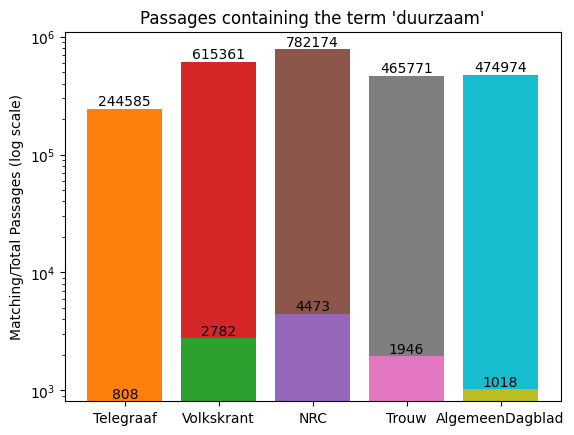

In [78]:
import matplotlib.pyplot as plt

assert text_widget.value.strip(), "No search term provided"

fig, ax = plt.subplots()

ax.set_title(f"Passages containing the term '{text_widget.value}'")

scale = "log"
ax.set_ylabel(f"Matching/Total Passages ({scale} scale)")
ax.set_yscale(scale)

for collection in collection_selector.value:
    doc_freq = db.doc_frequency(
        text_widget.value, collection, metadata_not=metadata_not
    )
    total_count = db.doc_frequency("", collection, metadata_not=metadata_not)

    bar_matches = ax.bar(collection, doc_freq, label=f"{collection} - Matches")
    ax.bar_label(bar_matches, fmt="%d", label_type="edge")

    bar_total = ax.bar(
        collection,
        total_count - doc_freq,
        bottom=doc_freq,
        label=f"{collection} - Total",
    )
    ax.bar_label(bar_total, fmt="%d", label_type="edge")

# Frequencies Per Year

In [79]:
start = 1850
end = 2024

year_range = widgets.SelectionRangeSlider(
    options=[str(i) for i in range(start, end)], index=(100, 150), description="Years"
)
year_range

SelectionRangeSlider(description='Years', index=(100, 150), options=('1850', '1851', '1852', '1853', '1854', '…

In [80]:
normalize = widgets.Checkbox(
    value=True, description="Normalize Frequencies", disabled=False
)
normalize

Checkbox(value=True, description='Normalize Frequencies')

In [81]:
import pandas as pd
from tqdm import tqdm

doc_freqs = pd.DataFrame(
    index=range(int(year_range.value[0]), int(year_range.value[1]))
)

for collection in tqdm(collection_selector.value, unit="collection"):
    doc_freqs[collection] = [
        db.doc_frequency(
            text_widget.value,
            collection,
            {"year": str(year)},
            metadata_not=metadata_not,
            normalize=normalize.value,
        )
        for year in doc_freqs.index
    ]

100%|██████████| 5/5 [00:30<00:00,  6.05s/collection]


<Axes: title={'center': "Normalized Frequency of 'duurzaam' (Rolling Average over 5 years)"}, xlabel='Year', ylabel='Normalized Frequency'>

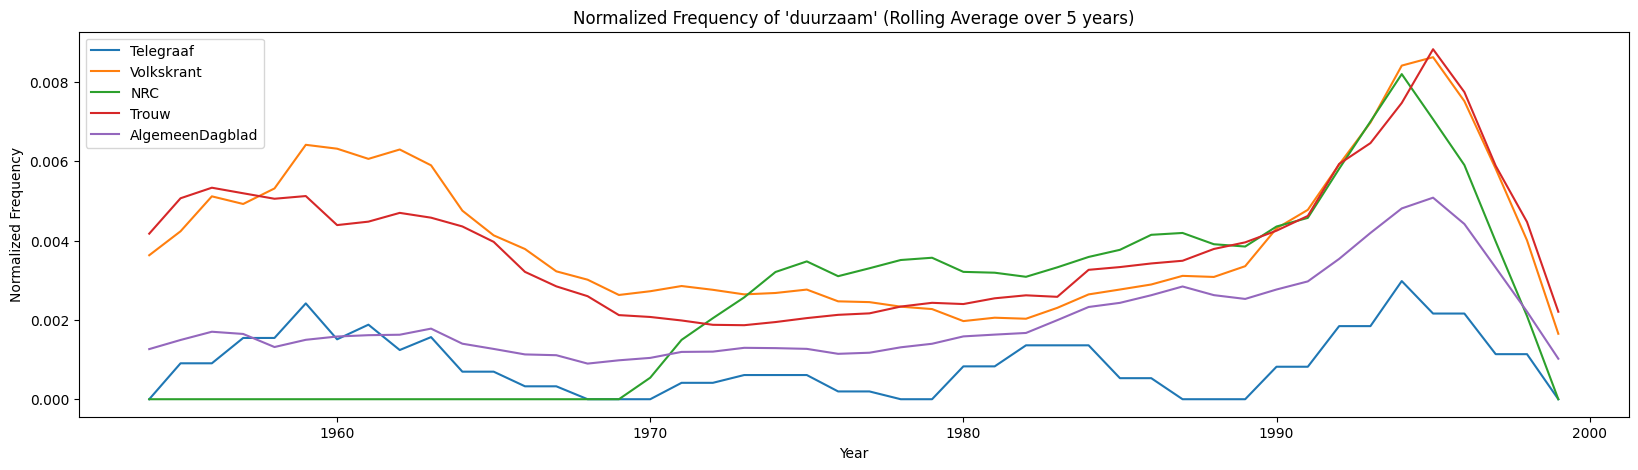

In [82]:
window_size = 5
_prefix = "Normalized " if normalize.value else ""

doc_freqs.rolling(window_size).mean().plot(
    figsize=(20, 5),
    title=f"{_prefix}Frequency of '{text_widget.value}' (Rolling Average over {window_size} years)",
    xlabel="Year",
    ylabel=f"{_prefix}Frequency",
)

# Create Corpus

In [83]:
%autoreload now

In [84]:
collections = [
    db.get_corpus(
        collection,
        [text_widget.value],
        year_from=year_range.value[0],
        year_to=year_range.value[1],
        include_embeddings=True,
        metadata_not=metadata_not,
    )
    for collection in collection_selector.value
]

## Expand Corpus with Close Passages

In [85]:
distance_widget = widgets.FloatSlider(
    value=0.4, min=0, max=1, step=0.01, description="Distance Threshold"
)

distance_widget

FloatSlider(value=0.4, description='Distance Threshold', max=1.0, step=0.01)

In [86]:
from tempo_embeddings.text.corpus import Corpus
from tempo_embeddings.text.passage import Passage
from tempo_embeddings.text.year_span import YearSpan

all_passages: set[Passage] = {
    passage for corpus in collections for passage in corpus.passages
}

neighbours: dict[Corpus, Corpus] = {
    collection: db.neighbours(
        collection,
        k=len(collection),  # at most, double the collection
        collections=collection_selector.value,
        distance=distance_widget.value,
        year_span=YearSpan(year_range.value[0], year_range.value[1]),
        metadata_not=metadata_not,
        exclude_passages=all_passages,
    )
    for collection in tqdm(collections, unit="collection", desc="Getting Neighbours")
}

Getting Neighbours: 100%|██████████| 5/5 [00:11<00:00,  2.21s/collection]


In [87]:
label_length: int = max(len(collection.label) for collection in collections)

print(
    f"{'Collection Label'.ljust(label_length)}\tSize\tNeighbours with Distance < {distance_widget.value}"
)
for collection in collections:
    print(
        f"{collection.label.ljust(label_length)}\t{len(collection)}\t{len(neighbours[collection])}"
    )

Collection Label           	Size	Neighbours with Distance < 0.4
Telegraaf: 'duurzaam'      	461	32
Volkskrant: 'duurzaam'     	2189	158
NRC: 'duurzaam'            	1894	159
Trouw: 'duurzaam'          	1859	172
AlgemeenDagblad: 'duurzaam'	1018	47


# Merge Collections

In [97]:
%autoreload now

In [98]:
from tempo_embeddings.text.corpus import Corpus

corpus = sum(collections + list(neighbours.values()), Corpus())
corpus.label = "Newspapers plus Neighbours"

In [99]:
from tempo_embeddings.settings import STOPWORDS
from tempo_embeddings.text.keyword_extractor import KeywordExtractor

keyword_extractor = KeywordExtractor(
    corpus, exclude_words=STOPWORDS | {text_widget.value}
).fit()

/Users/carstenschnober/Documents/SemanticsOfSustainability/workspace/tempo-embeddings/.venv/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


## Cluster Corpus

In [100]:
if all(
    (
        passage.metadata["provenance"].startswith("NRC_")
        for passage in corpus.passages
        if "newspaper" not in passage.metadata
    )
):
    fillna_newspaper = "NRC"
else:
    # This happens if we combine newspapers and non-newspapers here
    raise RuntimeError(
        "Cannot determine how to fill empty 'newspaper' metadata fields."
    )

In [101]:
corpus.compress_embeddings()

array([[11.1181221 ,  2.45289707],
       [11.08026886,  1.98694253],
       [ 9.65446949,  4.21281338],
       ...,
       [ 6.29642057,  2.9839797 ],
       [12.97505665,  3.84690833],
       [10.49161625,  7.31546736]])

In [102]:
clusters = list(
    corpus.cluster(
        use_2d_embeddings=True,
        max_clusters=50,
        cluster_selection_method="leaf",
        min_cluster_size=20,
        min_samples=5,
    )
)
len(clusters)

36

In [103]:
from tempo_embeddings.settings import STOPWORDS

for c in clusters:
    c.top_words = keyword_extractor.top_words(c, min_words=1, max_words=10)

Text(0.5, 1.0, "Cluster Sizes for 'duurzaam'")

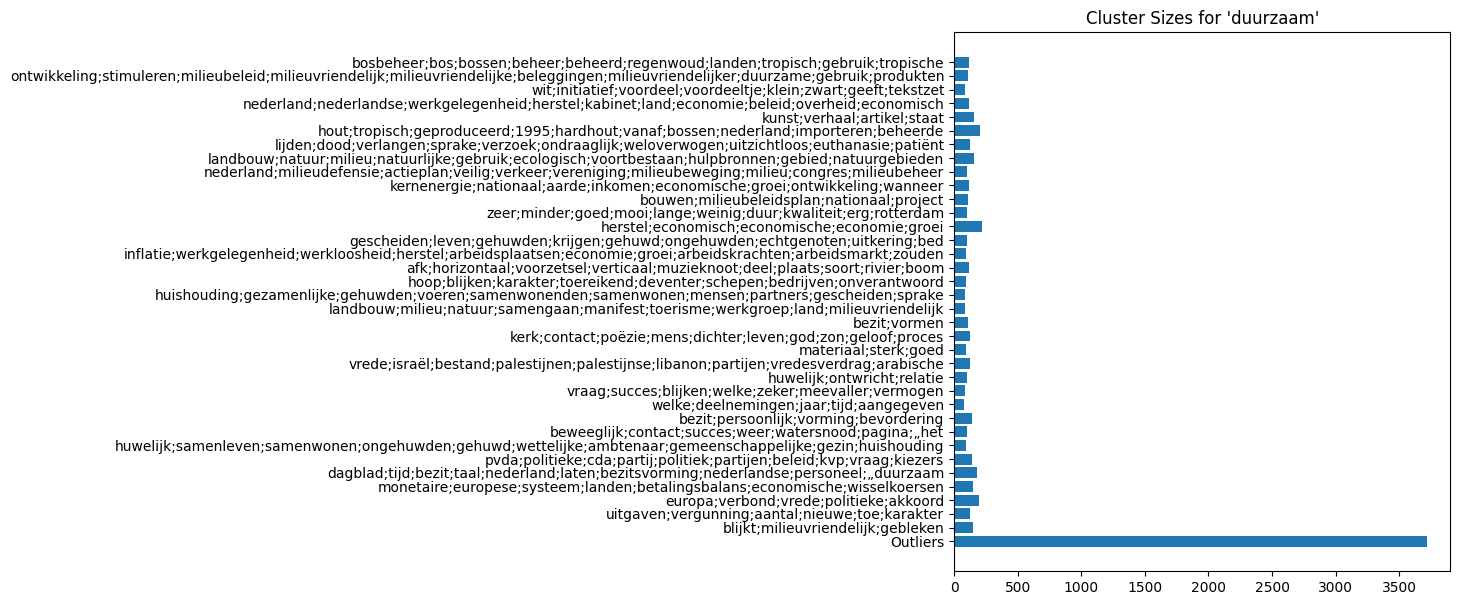

In [104]:
fig, ax = plt.subplots()
fig.set_figheight(len(clusters) // 5)

ax.barh([c.top_words_string() for c in clusters], [len(c) for c in clusters])
ax.set_title(f"Cluster Sizes for '{text_widget.value}'")

In [105]:
import os

from bokeh.io import output_notebook
from bokeh.plotting import show

from tempo_embeddings.visualization.bokeh import BokehInteractiveVisualizer

try:
    del visualizer
except NameError:
    pass

corpora = clusters + list(neighbours.values())
visualizer = BokehInteractiveVisualizer(
    *corpora, legend_label_func=Corpus.top_words_string, width=1500, height=500
)

os.environ["BOKEH_ALLOW_WS_ORIGIN"] = "*"

output_notebook()

show(visualizer.create_document)

Loading BokehJS ...

# Cluster-based Statistics

In [106]:
import random

cluster_selector = widgets.Dropdown(
    options=[(cluster.top_words_string(), i) for i, cluster in enumerate(clusters)],
    value=random.randint(0, len(clusters) - 1),
    description="Choose a Cluster:",
)
cluster_selector

Dropdown(description='Choose a Cluster:', index=23, options=(('Outliers', 0), ('blijkt;milieuvriendelijk;geble…

In [107]:
cluster: Corpus = clusters[cluster_selector.value]

<Axes: title={'center': "Relative frequency of cluster 'herstel;economisch;economische;economie;groei' by newspaper"}, xlabel='newspaper', ylabel='Sentence Count'>

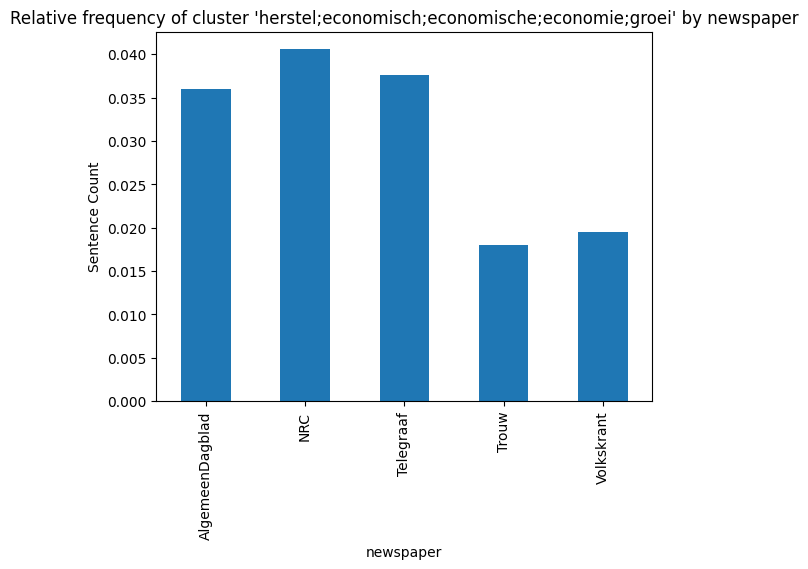

In [108]:
field = "newspaper"


corpus_per_newspaper = pd.Series(
    corpus.get_metadatas(field, default_value=fillna_newspaper)
).value_counts()

cluster_per_newspaper = pd.Series(
    cluster.get_metadatas(field, default_value=fillna_newspaper)
).value_counts()

(cluster_per_newspaper / corpus_per_newspaper).sort_index().plot(
    kind="bar",
    title=f"Relative frequency of cluster '{cluster.top_words_string()}' by {field}",
    xlabel=field,
    ylabel="Sentence Count",
)

In [109]:
field = "year"

corpus_per_year = pd.Series(
    corpus.get_metadatas(field, default_value=None)
).value_counts()

<Axes: title={'center': "Cluster 'herstel;economisch;economische;economie;groei' (Rolling average over 5 years)"}, xlabel='year', ylabel='Sentence Count'>

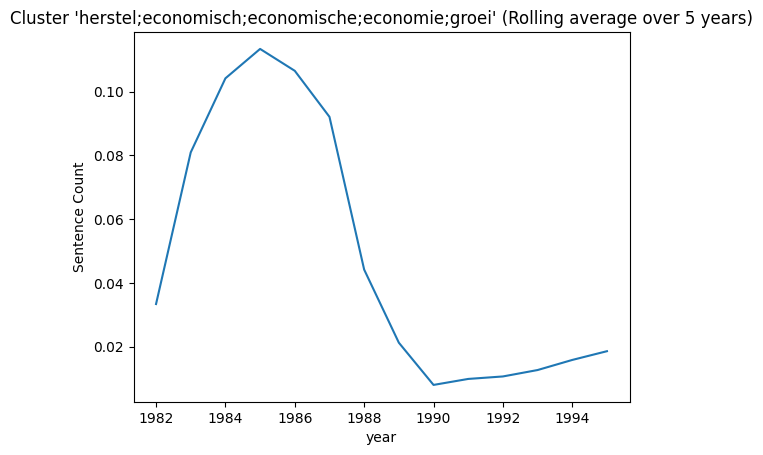

In [110]:
cluster_per_year = pd.Series(
    cluster.get_metadatas(field, default_value=None)
).value_counts()

(cluster_per_year / corpus_per_year).sort_index().rolling(window_size).mean().plot(
    title=f"Cluster '{cluster.top_words_string()}' (Rolling average over {window_size} years)",
    xlabel=field,
    ylabel="Sentence Count",
)

In [111]:
clusters_per_year = []
for c in clusters:
    if not c.is_outliers():
        s = (
            pd.Series(c.get_metadatas(field, default_value=None)).value_counts()
            / corpus_per_year
        )
        s.name = c.top_words_string()
        clusters_per_year.append(s)

clusters_per_year = pd.concat(clusters_per_year, axis=1)

<Axes: title={'center': 'Yearly Distribution of Clusters'}>

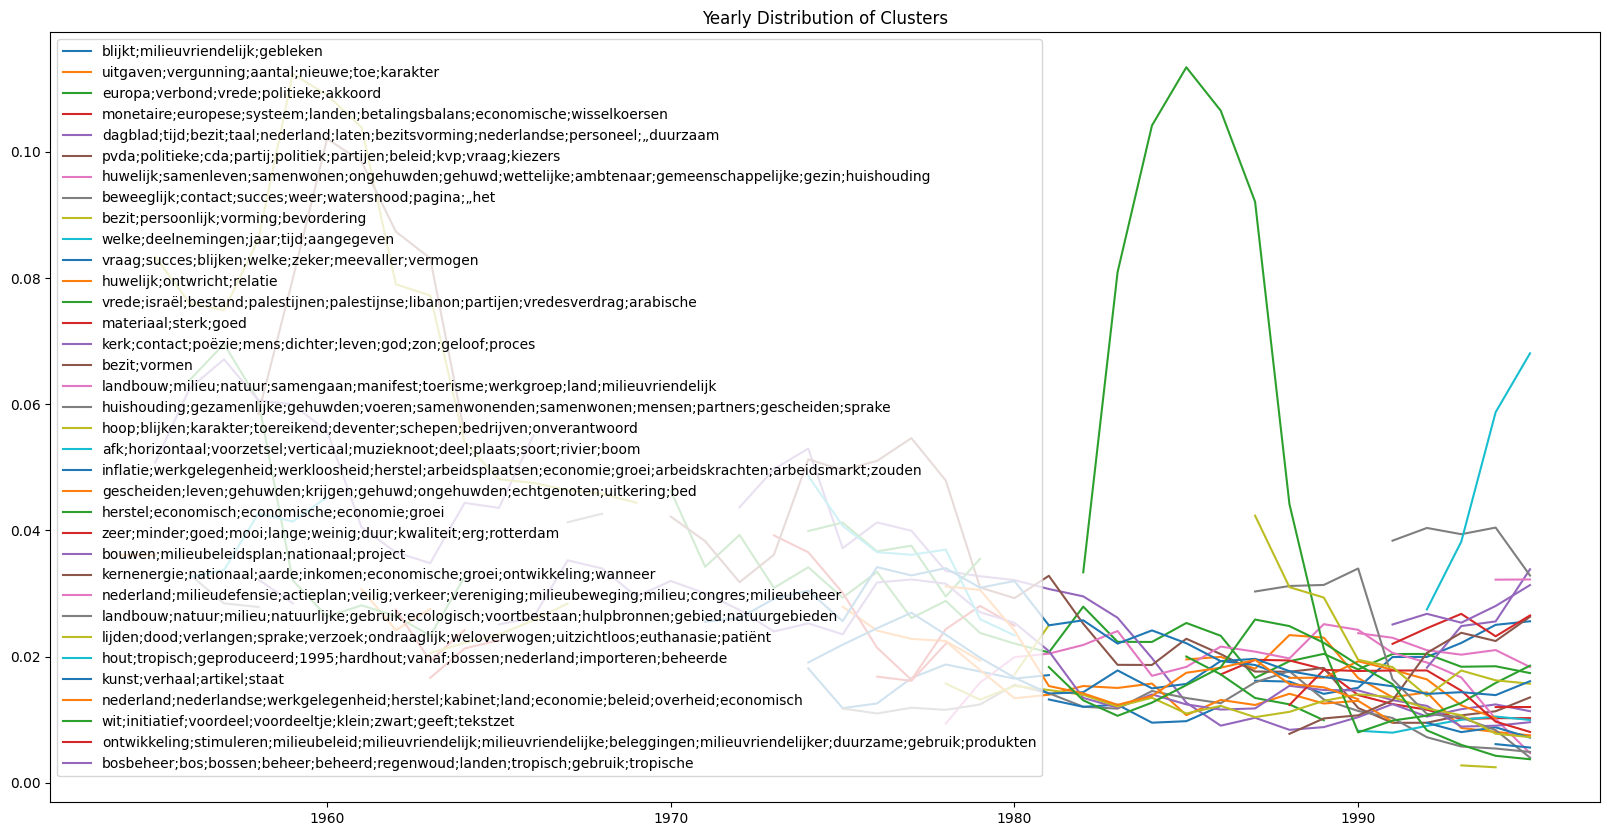

In [112]:
clusters_per_year.sort_index().rolling(window_size).mean().plot(
    kind="line", figsize=(20, 10), title="Yearly Distribution of Clusters"
)

## Cluster Analysis per Years

In [113]:
windows = sorted(
    cluster.windows(5, start=int(year_range.value[0]), stop=int(year_range.value[1])),
    key=lambda c: c.label,
)

In [115]:
print(f"Windows for cluster '{cluster}':")
for window in windows:
    window.top_words = keyword_extractor.top_words(window)

    print(window)

Windows for cluster 'Corpus('Newspapers plus Neighbours; cluster 29', 222 passages, top words=['herstel', 'economisch', 'economische', 'economie', 'groei'])':
Corpus('Newspapers plus Neighbours; cluster 29 1955-1960', 3 passages, top words=['marktbeleid', 'rechtvaardigen', 'achtte', 'prijsbeheersing', 'marktverhoudingen', 'prijsbeheersingsregeling', 'bestendig', 'tegenwoordige', 'bezwaar', 'wettelijke'])
Corpus('Newspapers plus Neighbours; cluster 29 1960-1965', 5 passages, top words=['negatieve', 'argumenten', 'factoren', 'beste', 'nooit', 'resultaat', 'begrip', 'aantrekkingskracht', 'gedifferentieerde'])
Corpus('Newspapers plus Neighbours; cluster 29 1965-1970', 3 passages, top words=['betwijfeld', 'herstel', 'expansie', 'nationale', 'situatie', 'bevordering', 'bngland', 'terugbetaling', 'gesaneerd', 'laats'])
Corpus('Newspapers plus Neighbours; cluster 29 1970-1975', 6 passages, top words=['waarnaast', 'staatsuitgaven', 'dwingt', 'verlagen', 'opgetreden', 'dringen', 'noodzaak', 'fin

In [116]:
import os

from bokeh.io import output_notebook
from bokeh.plotting import show

from tempo_embeddings.visualization.bokeh import BokehInteractiveVisualizer

try:
    del visualizer
except NameError:
    pass

visualizer = BokehInteractiveVisualizer(*windows, width=1500, height=500)

os.environ["BOKEH_ALLOW_WS_ORIGIN"] = "*"

output_notebook()

show(visualizer.create_document)

Loading BokehJS ...

In [119]:
cluster_extractor = KeywordExtractor(
    cluster, exclude_words=STOPWORDS | {text_widget.value}
).fit()

In [121]:
print(
    f"Frequent words per window relative to this cluster ({cluster.top_words_string()}):"
)
print("-" * 80)

for window in windows:
    print(window)
    print(cluster_extractor.top_words(window))

Frequent words per window relative to this cluster (herstel;economisch;economische;economie;groei):
--------------------------------------------------------------------------------
Corpus('Newspapers plus Neighbours; cluster 29 1955-1960', 3 passages, top words=['marktbeleid', 'rechtvaardigen', 'achtte', 'prijsbeheersing', 'marktverhoudingen', 'prijsbeheersingsregeling', 'bestendig', 'tegenwoordige', 'bezwaar', 'wettelijke'])
['marktbeleid', 'rechtvaardigen', 'achtte', 'marktverhoudingen', 'bezwaar', 'bestendig', 'enkel', 'prijsbeheersingsregeling', 'prijsbeheersing', 'tegenwoordige']
Corpus('Newspapers plus Neighbours; cluster 29 1960-1965', 5 passages, top words=['negatieve', 'argumenten', 'factoren', 'beste', 'nooit', 'resultaat', 'begrip', 'aantrekkingskracht', 'gedifferentieerde'])
['nooit', 'argumenten', 'negatieve', 'begrip', 'beste', 'resultaat', 'factoren', 'brengen']
Corpus('Newspapers plus Neighbours; cluster 29 1965-1970', 3 passages, top words=['betwijfeld', 'herstel', 'ex